In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from os import environ
!mamba run -n tf_on_gpu pip install -q pyarrow

2022-12-09 15:05:32.162964: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
tf.test.gpu_device_name()

2022-12-09 15:05:36.847996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


''

In [3]:
from feather_io import FeatherReader    

train_dataset = FeatherReader(environ.get("TRAIN_DATA", "acceptance-train")).as_tf_dataset()
validation_dataset = FeatherReader(environ.get("VALIDATION_DATA", "acceptance-validation")).as_tf_dataset()

/usr/local/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
X, y = next(iter(train_dataset.batch(1_000_000)))
X.shape

TensorShape([1000000, 10])

In [5]:
#model_type = 'pure_sequential'
model_type = 'with_residual_layers'

In [6]:
if model_type == 'pure_sequential':
    layers = []
    layers += [tf.keras.layers.Dense(
        128, 
        activation='tanh', 
        kernel_initializer='he_normal', 
        kernel_regularizer=tf.keras.regularizers.L2(1e-3)) for _ in range(4)]

    model = tf.keras.models.Sequential()
    for layer in layers:
        model.add(layer)
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.build(input_shape = [None, X.shape[1]])
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 51,073
Trainable params: 51,073
Non-trainable params: 0
_________________________________________________________________


In [7]:
if model_type == 'with_residual_layers':
    input = tf.keras.layers.Input(batch_input_shape=[None]+X.shape[1:])
    x = tf.keras.layers.Dense(
        128, activation='tanh',
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.L2(1e-3)
    )(input)

    for i in range(10):
        r = tf.keras.layers.Dense(128, activation='tanh', kernel_initializer='zeros')(x)
        x = tf.keras.layers.Add()([x, r])
    x = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)

    model = tf.keras.Model(inputs=[input], outputs=[x])
    model.summary()

In [8]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop

In [9]:
model.compile(loss=BinaryCrossentropy(label_smoothing=0.01), optimizer=RMSprop(10e-3))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

batch_size=100_000

training_data = train_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
validation_data=next(iter(validation_dataset.batch(batch_size)))

history = model.fit(training_data, epochs=50, validation_data=validation_data, callbacks=[early_stopping])

Epoch 1/50
26/26 [==============================] - 8s 282ms/step - loss: 1.7036 - val_loss: 1.1965
Epoch 2/50
26/26 [==============================] - 7s 264ms/step - loss: 1.0567 - val_loss: 0.8678
Epoch 3/50
26/26 [==============================] - 7s 266ms/step - loss: 0.7948 - val_loss: 0.6691
Epoch 4/50
26/26 [==============================] - 7s 283ms/step - loss: 0.6964 - val_loss: 0.6556
Epoch 5/50
26/26 [==============================] - 7s 268ms/step - loss: 0.6334 - val_loss: 1.0837
Epoch 6/50
26/26 [==============================] - 7s 265ms/step - loss: 0.6149 - val_loss: 0.5780
Epoch 7/50
26/26 [==============================] - 7s 268ms/step - loss: 0.5950 - val_loss: 0.5534
Epoch 8/50
26/26 [==============================] - 7s 268ms/step - loss: 0.5482 - val_loss: 0.6898
Epoch 9/50
26/26 [==============================] - 7s 272ms/step - loss: 0.6071 - val_loss: 0.5405
Epoch 10/50
26/26 [==============================] - 7s 267ms/step - loss: 0.5605 - val_loss: 0.4892

In [10]:
model.compile(loss=BinaryCrossentropy(label_smoothing=0.00), optimizer=RMSprop(1e-3))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history_ft = model.fit(training_data, epochs=50, validation_data=validation_data, callbacks=[early_stopping])

Epoch 1/50
26/26 [==============================] - 8s 266ms/step - loss: 0.4855 - val_loss: 0.4627
Epoch 2/50
26/26 [==============================] - 7s 273ms/step - loss: 0.4501 - val_loss: 0.4409
Epoch 3/50
26/26 [==============================] - 7s 276ms/step - loss: 0.4361 - val_loss: 0.4304
Epoch 4/50
26/26 [==============================] - 10s 367ms/step - loss: 0.4283 - val_loss: 0.4269
Epoch 5/50
26/26 [==============================] - 10s 367ms/step - loss: 0.4227 - val_loss: 0.4213
Epoch 6/50
26/26 [==============================] - 7s 262ms/step - loss: 0.4194 - val_loss: 0.4168
Epoch 7/50
26/26 [==============================] - 7s 266ms/step - loss: 0.4161 - val_loss: 0.4144
Epoch 8/50
26/26 [==============================] - 7s 276ms/step - loss: 0.4140 - val_loss: 0.4117
Epoch 9/50
26/26 [==============================] - 7s 260ms/step - loss: 0.4119 - val_loss: 0.4169
Epoch 10/50
26/26 [==============================] - 7s 267ms/step - loss: 0.4106 - val_loss: 0.40

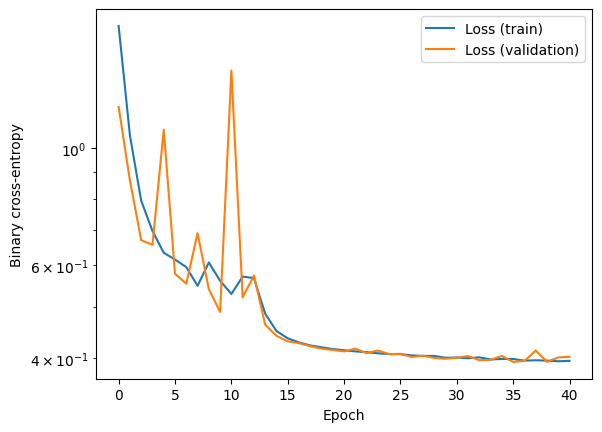

In [11]:
plt.plot(history.history['loss'] + history_ft.history['loss'], label="Loss (train)")
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label="Loss (validation)")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy")
plt.yscale('log')
plt.legend()
plt.show()

1/1 [==============================] - 0s 313ms/step


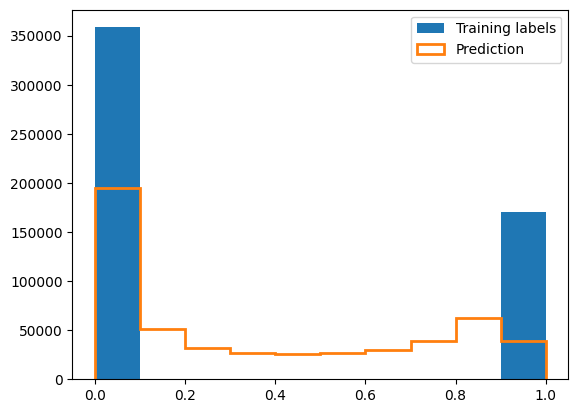

In [12]:
Xv, yv = next(iter(validation_dataset.batch(1_000_000).as_numpy_iterator()))
yv_hat = model.predict(Xv, batch_size=len(Xv))
bins = np.linspace(0, 1, 11)
plt.hist(yv, bins=bins, label="Training labels")
plt.hist(yv_hat, bins=bins, histtype='step', linewidth=2, label="Prediction")
plt.legend()
plt.show()

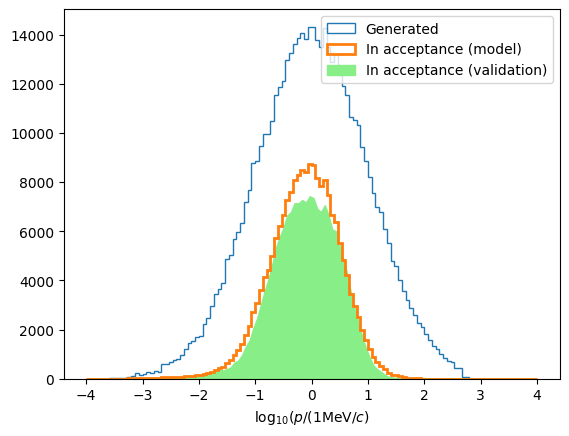

In [13]:
log_p = Xv[:,3]
bins = np.linspace(-4, 4, 121)
denominator, _ = np.histogram(log_p, bins=bins)
true_numerator, _ = np.histogram(log_p, bins=bins, weights=yv.flatten())
predicted_numerator, _ = np.histogram(log_p, bins=bins, weights=yv_hat.flatten())

plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=denominator, label="Generated", histtype='step')
plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=predicted_numerator, label="In acceptance (model)", histtype='step', linewidth=2)
#plt.plot((bins[1:] + bins[:-1])/2, predicted_numerator, label="In acceptance (model)")
plt.fill_between(
    (bins[1:] + bins[:-1])/2, np.zeros(len(true_numerator)), true_numerator,
    label="In acceptance (validation)",
    color='#88ee88'
)
plt.xlabel(r"$\log_{10} \left(p / (1 \mathrm{MeV}/c\right)$")
plt.legend()
plt.show()

In [19]:
import os
default_output_model = "/workarea/cloud-storage/anderlinil/models/acceptance"
output_model = os.path.dirname(environ['OUTPUT_MODEL']) if 'OUTPUT_MODEL' in environ else default_output_model
base_dir = os.path.dirname(output_model)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
model.save(output_model)

INFO:tensorflow:Assets written to: /workarea/cloud-storage/anderlinil/models/acceptance/assets
